In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

### Importing required libraries

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.applications.vgg19 import VGG19
from keras.layers import Dense,Conv2D,MaxPool2D,Flatten
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator,load_img
from glob import glob
import cv2

TypeError: Descriptors cannot be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

### Visualising blood cell images

(-0.5, 156.5, 144.5, -0.5)

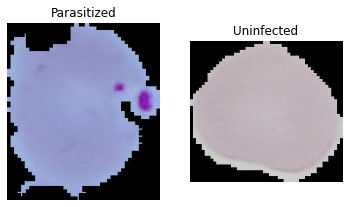

In [ ]:
# creating subplot of any 2 random samples (1 from each category)
# parasitized
plt.subplot(1,2,1)
plt.imshow(cv2.imread('cell_images/Parasitized/C60P21thinF_IMG_20150804_113602_cell_125.png'))
plt.title('Parasitized')
plt.axis('off')
# uninfected
plt.subplot(1,2,2)
plt.imshow(cv2.imread('cell_images/Uninfected/C203ThinF_IMG_20151029_102123_cell_51.png'))
plt.title('Uninfected')
plt.axis('off')

### Splitting images into train and test dataset

In [ ]:
# using ImageDataGenerator to rescale all images and spliiting with 80% train and 20% validation
data = ImageDataGenerator(rescale=1/255.0, validation_split=0.2)

In [ ]:
# traini_Set with image_size=(224,224),class_mode='binary' and subset='training'
train_set=data.flow_from_directory(directory='cell_images/',
                                   target_size=(224,224),
                                    class_mode='binary',
                                    batch_size=32,
                                    subset='training'
                                   )

Found 22048 images belonging to 2 classes.


In [ ]:
# test_set with same features but subset='validation'
test_set=data.flow_from_directory(directory='cell_images/',
                                   target_size=(224,224),
                                    class_mode='binary',
                                    batch_size=32,
                                    subset='validation'
                                   )

Found 5510 images belonging to 2 classes.


### Initializing our VGG19 model

In [ ]:
# weights initialisation from imagenet nad top layer is not included since we have our own categories
vgg19=VGG19(input_shape=[224,224,3],weights='imagenet',include_top=False)

80142336/80134624 [==============================] - 2s 0us/step


In [ ]:
# we don't want to train the vgg19 model layers again
for layer in vgg19.layers:
    layer.trainable=False

In [ ]:
# adding our own flatten layer
x=Flatten()(vgg19.output)
# creating a prediction dense layer with activation of softmax after x layer created above
prediction=Dense(2,activation='softmax')(x)
# model is created with inputs from vgg19 and outputs as our prediction layer
model=Model(inputs=vgg19.input,outputs=prediction)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
# compiling of our customized model
model.compile(
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy']
)

### Training of model

In [ ]:
# fitting our training data and saving results in history 
history = model.fit_generator(generator = train_set,
                              validation_data = test_set,
                              epochs =5)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
689/689 [==============================] - 218s 311ms/step - loss: 0.5705 - accuracy: 0.7816 - val_loss: 0.3661 - val_accuracy: 0.8523
Epoch 2/5
689/689 [==============================] - 73s 107ms/step - loss: 0.2702 - accuracy: 0.8913 - val_loss: 0.2722 - val_accuracy: 0.8864
Epoch 3/5
689/689 [==============================] - 73s 106ms/step - loss: 0.1989 - accuracy: 0.9236 - val_loss: 0.3099 - val_accuracy: 0.8808
Epoch 4/5
689/689 [==============================] - 73s 106ms/step - loss: 0.1806 - accuracy: 0.9319 - val_loss: 0.2744 - val_accuracy: 0.8969
Epoch 5/5
689/689 [==============================] - 72s 105ms/step - loss: 0.1701 - accuracy: 0.9344 - val_loss: 0.2469 - val_accuracy: 0.9058


### Plotting Accuracy

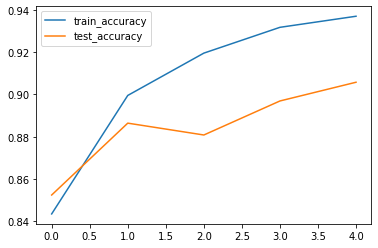

In [ ]:
plt.plot(history.history['accuracy'],label='train_accuracy')
plt.plot(history.history['val_accuracy'],label='test_accuracy')
plt.legend()
plt.show()

In [ ]:
# saving our model in a .h5 file
from tensorflow.keras.models import load_model
model.save('malaria_vgg19.h5')

In [ ]:
y_pred=model.predict(test_set)
y_pred[:10]

array([[9.9784613e-01, 2.1538339e-03],
       [9.9789053e-01, 2.1094310e-03],
       [9.9973887e-01, 2.6113429e-04],
       [9.9999511e-01, 4.8779457e-06],
       [9.4893500e-02, 9.0510654e-01],
       [9.9949110e-01, 5.0889060e-04],
       [2.2047255e-02, 9.7795278e-01],
       [9.9999368e-01, 6.2797731e-06],
       [9.8637551e-01, 1.3624493e-02],
       [1.2824334e-01, 8.7175673e-01]], dtype=float32)

In [ ]:
predictions=np.argmax(y_pred,axis=1)
predictions[:10]

array([0, 0, 0, 0, 1, 0, 1, 0, 0, 1])